#   UTS PPW

# 1. Analisis Klasifikasi Berita dengan Topik Modelling + Naive Bayes & SVM

In [11]:
# Setup dependensi utama
# !pip install pandas numpy scikit-learn matplotlib seaborn nltk Sastrawi gensim pyLDAvis

import os
import sys
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Teks & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import re
import string

# Gensim untuk LDA (topik modelling)
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# NLTK & stopwords/stemmer Bahasa Indonesia
import nltk
from nltk.corpus import stopwords
try:
    _ = stopwords.words('indonesian')  # uji ketersediaan stopwords
except LookupError:
    nltk.download('stopwords')  # unduh jika belum ada
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Lokasi CSV di workspace saat ini (fallback ke cwd bila perlu)
DATA_PATH = r"Berita.csv"
if not os.path.exists(DATA_PATH):
    # Jika notebook dieksekusi dari folder lain, coba path alternatif
    DATA_PATH = os.path.join(os.getcwd(), 'Berita.csv')
print('Menggunakan path data:', DATA_PATH)



Menggunakan path data: Berita.csv


In [12]:
# Baca data dengan beberapa percobaan encoding (fallback bila format tidak standar)

read_attempts = [
    dict(encoding='utf-8', sep=','),   # default umum
    dict(encoding='utf-8', sep=';'),   # jika pemisah titik koma
    dict(encoding='latin-1', sep=','), # jika ada karakter Latin-1
    dict(encoding='latin-1', sep=';'),
]

# Coba baca berurutan sampai berhasil
df = None
err = None
for kw in read_attempts:
    try:
        df = pd.read_csv(DATA_PATH, **kw)
        print('Dibaca dengan:', kw)
        break
    except Exception as e:
        err = e
        continue

if df is None:
    # Naikkan error terakhir agar mudah ditelusuri
    raise RuntimeError(f'Gagal membaca CSV. Error terakhir: {err}')

print('Dimensi:', df.shape)
df


Dibaca dengan: {'encoding': 'utf-8', 'sep': ','}
Dimensi: (1500, 6)


,No,judul,berita,tanggal,kategori,link
0,1,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Menteri Koordinator (Menko) Bidang Perekonomia...,"Minggu, 01 Des 2024 23:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
1,2,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,"Dalam rangka memeriahkan hari jadi ke-50, PT S...","Minggu, 01 Des 2024 20:45 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
2,3,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Wacana Presiden Prabowo Subianto akan membentu...,"Minggu, 01 Des 2024 19:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
3,4,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,"Minggu, 01 Des 2024 19:03 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
4,5,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Pemerintah akan segera membentuk Satuan Tugas ...,"Minggu, 01 Des 2024 19:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
...,...,...,...,...,...,...
1495,1496,Laporan Sebab Tabrakan Pesawat-Black Hawk Dita...,Anggota Dewan Keselamatan Transportasi Nasiona...,"Jumat, 31 Jan 2025 04:40 WIB",Internasional,https://www.cnnindonesia.com/internasional/202...
1496,1497,"Israel Bebaskan 110 Sandera Palestina, Diantar...",Israel telah membebaskan 110 tahanan Palestina...,"Jumat, 31 Jan 2025 03:01 WIB",Internasional,https://www.cnnindonesia.com/internasional/202...
1497,1498,Hamas Konfirmasi Kematian Komandan Al Qassam M...,Hamas mengonfirmasi kematian kepala militernya...,"Jumat, 31 Jan 2025 02:30 WIB",Internasional,https://www.cnnindonesia.com/internasional/202...
1498,1499,Black Box American Airlines Ditemukan Usai Tab...,Tim penyelam diduga menemukan satu dari dua bl...,"Jumat, 31 Jan 2025 01:00 WIB",Internasional,https://www.cnnindonesia.com/internasional/202...


In [13]:
# Tetapkan kolom teks dan label sesuai skema data

text_col = 'berita'   # kolom berisi isi berita
label_col = 'kategori' # kolom target/label kategori

# Validasi nama kolom agar fail-fast bila berbeda
if text_col not in df.columns:
    raise ValueError(f"Kolom teks '{text_col}' tidak ditemukan pada data. Periksa nama kolom.")
if label_col not in df.columns:
    raise ValueError(f"Kolom label '{label_col}' tidak ditemukan pada data. Periksa nama kolom.")

print('Kolom teks   :', text_col)
print('Kolom label  :', label_col)


Kolom teks   : berita
Kolom label  : kategori


Ringkasan pembersihan:
 - Baris awal        : 1500
 - Hapus kosong/NaN  : 0
 - Hapus duplikat    : 0
 - Total akhir       : 1500

Kolom: ['No', 'judul', 'berita', 'tanggal', 'kategori', 'link']

Frekuensi nilai label (Top 10):
kategori
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64


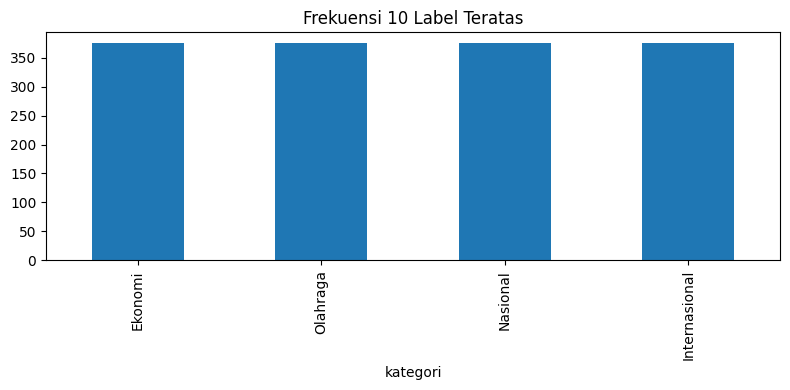

In [14]:
# EDA Dasar + Pembersihan Missing Value & Duplikat

# tipe string dan hilangkan spasi berlebih
df[text_col] = df[text_col].astype(str).fillna('').str.strip()
df[label_col] = df[label_col].astype(str).fillna('').str.strip()

# Buang baris kosong/NaN pada kolom teks/label
n_awal = len(df)
df = df[(df[text_col] != '') & (df[label_col] != '')]
n_setelah_kosong = len(df)

# Buang data duplikat berdasarkan teks berita
df = df.drop_duplicates(subset=[text_col])
n_setelah_duplikat = len(df)

print('Ringkasan pembersihan:')
print(' - Baris awal        :', n_awal)
print(' - Hapus kosong/NaN  :', n_awal - n_setelah_kosong)
print(' - Hapus duplikat    :', n_setelah_kosong - n_setelah_duplikat)
print(' - Total akhir       :', len(df))

print('\nKolom:', list(df.columns))
print('\nFrekuensi nilai label (Top 10):')
if label_col in df.columns:
    print(df[label_col].value_counts().head(10))

fig, ax = plt.subplots(1,1, figsize=(8,4))
if label_col in df.columns:
    df[label_col].value_counts().head(10).plot(kind='bar', ax=ax, title='Frekuensi 10 Label Teratas')
plt.tight_layout()
plt.show()


In [15]:
# Fungsi pra-pemrosesan untuk Bahasa Indonesia

punct_table = str.maketrans('', '', string.punctuation)
stop_id = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

USE_STEMMING = False

re_ws = re.compile(r"\s+")
re_url = re.compile(r"https?://\S+|www\.\S+")
re_num = re.compile(r"\d+")


def bersihkan_teks(text: str) -> str:
    text = text.lower()
    text = re_url.sub(' ', text)
    text = re_num.sub(' ', text)
    text = text.translate(punct_table)
    text = re_ws.sub(' ', text)
    return text.strip()


def normalisasi_dan_filter_token(text: str) -> str:
    text = bersihkan_teks(text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_id and len(t) > 2]
    if USE_STEMMING:
        tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

# Terapkan pra-pemrosesan
processed_text = df[text_col].map(normalisasi_dan_filter_token)
df_processed = pd.DataFrame({
    'text': processed_text,
    'label': df[label_col].values
})

df_processed


,text,label
0,menteri koordinator menko bidang perekonomian ...,Ekonomi
1,rangka memeriahkan surabaya industrial estate ...,Ekonomi
2,wacana presiden prabowo subianto membentuk mem...,Ekonomi
3,bpjs ketenagakerjaan kementerian agama kemenag...,Ekonomi
4,pemerintah membentuk satuan tugas pemutusan hu...,Ekonomi
...,...,...
1495,anggota dewan keselamatan transportasi nasiona...,Internasional
1496,israel membebaskan tahanan palestina kamis pem...,Internasional
1497,hamas mengonfirmasi kematian kepala militernya...,Internasional
1498,tim penyelam diduga menemukan black box kotak ...,Internasional


In [16]:
# Pembagian data latih-uji (stratified agar proporsi label seimbang di train/test)
X_train, X_test, y_train, y_test = train_test_split(
    df_processed['text'], df_processed['label'], test_size=0.2, random_state=42,
    stratify=df_processed['label'] if df_processed['label'].nunique()>1 else None  # aktif hanya jika multi-kelas
)

print('Jumlah latih:', len(X_train), '| Jumlah uji:', len(X_test), '| Jumlah kelas:', df_processed['label'].nunique())


Jumlah latih: 1200 | Jumlah uji: 300 | Jumlah kelas: 4


In [17]:
# Fitur Topik (LDA Gensim): distribusi dokumen-topik

# Tokenisasi sederhana dari teks yang sudah dipra-proses
tokens_train = [doc.split() for doc in X_train]
tokens_test = [doc.split() for doc in X_test]

# Bangun kamus (dictionary) dan korpus BoW
dictionary = Dictionary(tokens_train)

corpus_train = [dictionary.doc2bow(tokens) for tokens in tokens_train]
corpus_test = [dictionary.doc2bow(tokens) for tokens in tokens_test]

# Latih model LDA Gensim
data_kwargs = dict(id2word=dictionary, num_topics=20, random_state=42)
lda_gensim = LdaModel(corpus=corpus_train, passes=5, alpha='auto', eta='auto', **data_kwargs)

# Tampilkan ringkasan topik (top-10 kata per topik)
print('Topik dan kata-kata teratas:')
for t in range(lda_gensim.num_topics):
    print(f'Topik {t:02d}:', lda_gensim.print_topic(t, topn=10))

# Ubah setiap dokumen menjadi vektor distribusi topik berdimensi tetap
def doc_topics_dense(lda_model, bow, num_topics):
    dense = np.zeros(num_topics, dtype=np.float32)
    for topic_id, prob in lda_model.get_document_topics(bow, minimum_probability=0.0):
        dense[topic_id] = prob
    return dense

n_topics = lda_gensim.num_topics
train_topic_features = np.vstack([doc_topics_dense(lda_gensim, bow, n_topics) for bow in corpus_train])
test_topic_features = np.vstack([doc_topics_dense(lda_gensim, bow, n_topics) for bow in corpus_test])

print('Bentuk fitur topik:', train_topic_features.shape)

# Klasifikasi berbasis fitur topik (tanpa TF-IDF)
nb_topics = MultinomialNB()
nb_topics.fit(train_topic_features, y_train)
nb_preds = nb_topics.predict(test_topic_features)

svm_topics = LinearSVC(random_state=42)
svm_topics.fit(train_topic_features, y_train)
svm_preds = svm_topics.predict(test_topic_features)

for name, preds in [('Naive Bayes (LDA Gensim)', nb_preds), ('Linear SVM (LDA Gensim)', svm_preds)]:
    acc = accuracy_score(y_test, preds)
    print(f'\nAkurasi {name}: {acc:.4f}')
    print(classification_report(y_test, preds))


Topik dan kata-kata teratas:
Topik 00: 0.008*"indonesia" + 0.007*"wni" + 0.004*"desa" + 0.004*"ahsanhendra" + 0.004*"negeri" + 0.004*"warga" + 0.004*"januari" + 0.004*"malaysia" + 0.003*"pemerintah" + 0.003*"negara"
Topik 01: 0.007*"erupsi" + 0.006*"gunung" + 0.006*"venezia" + 0.006*"psn" + 0.005*"trump" + 0.005*"semeru" + 0.004*"besuk" + 0.004*"masyarakat" + 0.004*"presiden" + 0.004*"cnn"
Topik 02: 0.007*"indonesia" + 0.006*"kpk" + 0.006*"negara" + 0.005*"orang" + 0.004*"tannos" + 0.004*"paulus" + 0.004*"pesawat" + 0.004*"anggota" + 0.003*"korupsi" + 0.003*"suara"
Topik 03: 0.021*"menit" + 0.018*"gol" + 0.016*"vietnam" + 0.012*"thailand" + 0.012*"gawang" + 0.011*"aff" + 0.010*"babak" + 0.010*"piala" + 0.010*"filipina" + 0.008*"pemain"
Topik 04: 0.034*"indonesia" + 0.028*"timnas" + 0.018*"piala" + 0.014*"pelatih" + 0.008*"shin" + 0.007*"pssi" + 0.007*"pemain" + 0.007*"tae" + 0.006*"kluivert" + 0.006*"sty"
Topik 05: 0.036*"laut" + 0.029*"pagar" + 0.012*"tangerang" + 0.009*"nelayan" + 0.

Jumlah dokumen: 1200 | Ukuran vocab: 31742 | Total token: 229893
Mode tokenisasi untuk HDP: standar
Vocab HDP: 31742


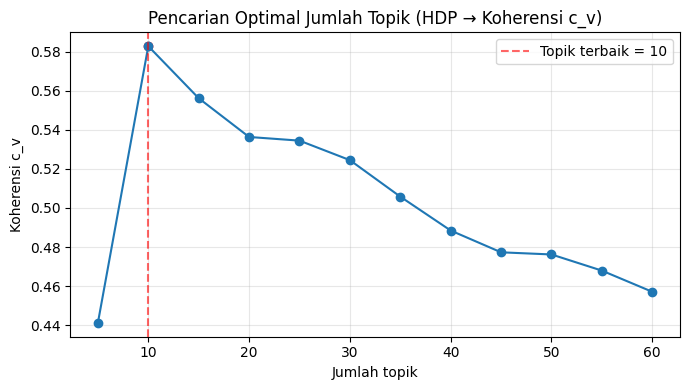

Topik terbaik menurut koherensi c_v: 10 (skor = 0.5828)


In [18]:
# Pencarian optimal dengan HDP: plot skor koherensi vs jumlah topik
from gensim.models import HdpModel, CoherenceModel

# Diagnostik dasar korpus/token
vocab_size = len(dictionary)
num_docs = len(tokens_train)
num_tokens_total = sum(len(t) for t in tokens_train)
print(f'Jumlah dokumen: {num_docs} | Ukuran vocab: {vocab_size} | Total token: {num_tokens_total}')

# Siapkan sumber token/dictionary/corpus untuk HDP
use_relaxed = False
if vocab_size < 20 or num_tokens_total < 200:
    # Relaksasi tokenisasi khusus untuk HDP bila korpus terlalu "tipis"
    use_relaxed = True
    tokens_for_hdp = [bersihkan_teks(doc).split() for doc in X_train]
    dictionary_hdp = Dictionary(tokens_for_hdp)
    corpus_hdp = [dictionary_hdp.doc2bow(toks) for toks in tokens_for_hdp]
    tokens_for_coherence = tokens_for_hdp
else:
    tokens_for_hdp = tokens_train
    dictionary_hdp = dictionary
    corpus_hdp = corpus_train
    tokens_for_coherence = tokens_train

print('Mode tokenisasi untuk HDP:', 'relaxed' if use_relaxed else 'standar')
print('Vocab HDP:', len(dictionary_hdp))

# Latih HDP dengan kapasitas topik lebih besar agar peluang topik muncul lebih tinggi
hdp_model = HdpModel(
    corpus=corpus_hdp,
    id2word=dictionary_hdp,
    T=150,   # max jumlah topik internal
    K=15,    # konsentrasi level pertama
)

# Ambil semua topik (diurutkan oleh strength)
all_topics = hdp_model.show_topics(num_topics=-1, num_words=15, formatted=False) or []

# Fallback: jika show_topics kosong, turunkan topik dari matriks topic-term
if len(all_topics) == 0:
    try:
        topic_term = hdp_model.get_topics()  # shape: (n_topics, |V|)
        # Konversi ke daftar [(topic_id, [(word, prob), ...])]
        all_topics = []
        if topic_term is not None and topic_term.size > 0:
            for tid, row in enumerate(topic_term):
                # Ambil 15 kata teratas per topik
                topn = min(15, row.shape[0])
                top_idx = np.argsort(row)[-topn:][::-1]
                words = [(dictionary_hdp[id_], float(row[id_])) for id_ in top_idx if row[id_] > 0]
                if len(words) > 0:
                    all_topics.append((tid, words))
    except Exception:
        pass

num_available_topics = len(all_topics)

if num_available_topics == 0:
    print('HDP tidak menghasilkan topik. Pertimbangkan untuk melonggarkan pra-pemrosesan atau perbesar korpus.')
else:
    # Tentukan rentang K yang valid (hindari K=0)
    max_k = min(60, num_available_topics)
    if max_k >= 5:
        k_values = list(range(5, max_k + 1, 5))
        if k_values[-1] != max_k:
            k_values.append(max_k)
    else:
        k_values = list(range(1, max_k + 1))

    coherence_scores = []
    valid_k_values = []

    # Hitung koherensi 'c_v' untuk masing-masing K; skip jika daftar topik kosong
    for k in k_values:
        # Normalisasi all_topics menjadi daftar kata per topik
        topics_k_pairs = all_topics[:k]
        topics_k = [
            [w for w, _ in (pair[1] if isinstance(pair[1], list) else pair)]
            for pair in topics_k_pairs
        ]
        topics_k = [tw for tw in topics_k if len(tw) > 0]
        if len(topics_k) == 0:
            continue
        try:
            cm = CoherenceModel(topics=topics_k, texts=tokens_for_coherence, dictionary=dictionary_hdp, coherence='c_v')
            coherence_scores.append(cm.get_coherence())
            valid_k_values.append(k)
        except (IndexError, ValueError):
            continue

    if len(valid_k_values) == 0:
        print('Tidak ada konfigurasi K valid untuk koherensi. Coba ubah pra-pemrosesan atau parameter.')
    else:
        # Tentukan K terbaik
        best_idx = int(np.argmax(coherence_scores))
        best_k = valid_k_values[best_idx]
        best_score = coherence_scores[best_idx]

        # Plot hasil pencarian
        plt.figure(figsize=(7,4))
        plt.plot(valid_k_values, coherence_scores, marker='o')
        plt.axvline(best_k, color='red', linestyle='--', alpha=0.6, label=f'Topik terbaik = {best_k}')
        plt.scatter([best_k], [best_score], color='red')
        plt.title('Pencarian Optimal Jumlah Topik (HDP → Koherensi c_v)')
        plt.xlabel('Jumlah topik')
        plt.ylabel('Koherensi c_v')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f'Topik terbaik menurut koherensi c_v: {best_k} (skor = {best_score:.4f})')


# 2. Clustering Dokumen Spam

In [19]:
# Setup & import
# !pip install pandas numpy scikit-learn matplotlib seaborn nltk Sastrawi

import os
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# NLTK stopwords (Indonesia + English)
import nltk
from nltk.corpus import stopwords
try:
    _ = stopwords.words('indonesian')
    _ = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

DATA_PATH = r"spam.csv"
print('Menggunakan path data:', os.path.abspath(DATA_PATH))


Menggunakan path data: d:\Tugas Semester 7\PPWeb\UTS\spam.csv


In [20]:
# Load data + validasi kolom
read_attempts = [
    dict(encoding='utf-8', sep=','),
    dict(encoding='latin-1', sep=','),
    dict(encoding='utf-8', sep=';'),
    dict(encoding='latin-1', sep=';'),
]

df = None
err = None
for kw in read_attempts:
    try:
        df = pd.read_csv(DATA_PATH, **kw)
        print('Dibaca dengan:', kw)
        break
    except Exception as e:
        err = e
        continue

if df is None:
    raise RuntimeError(f'Gagal membaca CSV: {err}')

# Normalisasi nama kolom agar toleran (misal "text" vs "Text")
cols_lower = {c.lower(): c for c in df.columns}
expected_cols = ['id', 'text']
missing = [c for c in expected_cols if c not in cols_lower]
if missing:
    raise ValueError(f"Kolom wajib hilang: {missing}. Kolom tersedia: {list(df.columns)}")

id_col = cols_lower['id']
text_col = cols_lower['text']

# Tipe & bersihkan kosong
df[id_col] = df[id_col].astype(str)
df[text_col] = df[text_col].astype(str).fillna('').str.strip()

n_awal = len(df)
df = df[df[text_col] != '']
print('Baris awal:', n_awal, '| Baris setelah buang kosong:', len(df))

print(df[[id_col, text_col]].head())


Dibaca dengan: {'encoding': 'latin-1', 'sep': ','}
Baris awal: 5572 | Baris setelah buang kosong: 5572
  id                                               Text
0  1  Go until jurong point, crazy.. Available only ...
1  2                      Ok lar... Joking wif u oni...
2  3  Free entry in 2 a wkly comp to win FA Cup fina...
3  4  U dun say so early hor... U c already then say...
4  5  Nah I don't think he goes to usf, he lives aro...


In [21]:
# Pra-pemrosesan teks
punct_table = str.maketrans('', '', string.punctuation)
re_ws = re.compile(r"\s+")
re_url = re.compile(r"https?://\S+|www\.\S+")
re_num = re.compile(r"\d+")

stop_id = set(stopwords.words('indonesian'))
stop_en = set(stopwords.words('english'))
stop_all = stop_id | stop_en


def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re_url.sub(' ', text)
    text = re_num.sub(' ', text)
    text = text.translate(punct_table)
    text = re_ws.sub(' ', text)
    text = text.strip()
    return text


def normalize_and_filter(text: str) -> str:
    text = clean_text(text)
    tokens = [t for t in text.split() if t not in stop_all and len(t) > 2]
    return ' '.join(tokens)

processed = df[text_col].map(normalize_and_filter)

print('Contoh sebelum/selepas:')
for i in range(3):
    print('-', df[text_col].iloc[i][:80])
    print(' ', processed.iloc[i][:80])


Contoh sebelum/selepas:
- Go until jurong point, crazy.. Available only in bugis n great world la e buffet
  jurong point crazy available bugis great world buffet cine got amore wat
- Ok lar... Joking wif u oni...
  lar joking wif oni
- Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8
  free entry wkly comp win cup final tkts may text receive entry questionstd txt r


Shape TF-IDF: (5572, 8339)
k=2: silhouette=0.0053
k=3: silhouette=0.0052
k=4: silhouette=0.0060
k=5: silhouette=0.0080
k=6: silhouette=0.0082
k=7: silhouette=0.0083
k=8: silhouette=0.0127
k=9: silhouette=0.0130
k=10: silhouette=0.0069


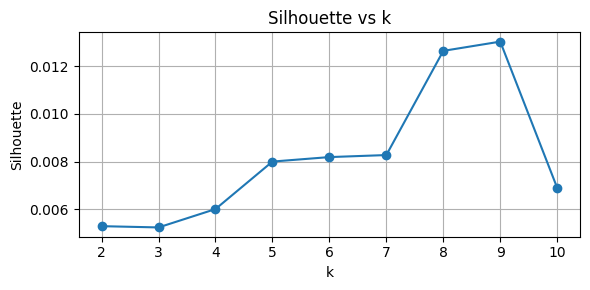

Best k: 9


In [22]:
# TF-IDF + pemilihan k via Silhouette
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X = vectorizer.fit_transform(processed)
print('Shape TF-IDF:', X.shape)

k_values = list(range(2, 11))
scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels, sample_size=1000 if X.shape[0]>1000 else None, random_state=42)
    scores.append(score)
    print(f'k={k}: silhouette={score:.4f}')

# Plot
plt.figure(figsize=(6,3))
plt.plot(k_values, scores, marker='o')
plt.title('Silhouette vs k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = k_values[int(np.argmax(scores))]
print('Best k:', best_k)


In [23]:
# Train KMeans dengan best_k, assign cluster, top terms, ekspor
km = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels = km.fit_predict(X)

# Tambah ke dataframe
out = df[[id_col, text_col]].copy()
out['cluster'] = labels

# Top terms per cluster
terms = np.array(vectorizer.get_feature_names_out())
order_centroids = np.argsort(km.cluster_centers_, axis=1)[:, ::-1]

print('\nTop terms per cluster:')
for i in range(best_k):
    top_terms = terms[order_centroids[i, :15]]
    print(f'Cluster {i}:', ', '.join(top_terms))

# Ekspor
afname = 'spam_clusters.csv'
out.to_csv(afname, index=False)
print('Disimpan ke:', os.path.abspath(afname))



Top terms per cluster:
Cluster 0: like, feel like, would, feel, dat, like dat, dun, something, would like, something like, like hour, get, know, dont, one
Cluster 1: good, well, morning, day, good morning, hope, night, love, great, sleep, good night, hope good, goes, time, care
Cluster 2: dont, know, dont know, want, dont want, dont worry, dont think, get, worry, anything, think, sorry, dont forget, much, let
Cluster 3: call, free, prize, claim, please call, please, urgent, mobile, ppm, customer, cash, contact, guaranteed, box, service
Cluster 4: tell, lol, come, tone, week, ill tell, get, ill, nokia, need, ptone, pls, week txt, please tell, mob
Cluster 5: call later, ill call, sorry ill, later, sorry, ill, call, meeting, later meeting, meeting call, meeting ill, sorryin meeting, sorryin, film, bye
Cluster 6: get, come, lor, going, home, ill, time, send, still, want, see, one, know, need, text
Cluster 7: ltgt, ltgt min, like ltgt, min, like, ltgt minutes, minutes, ltgt mins, around, l

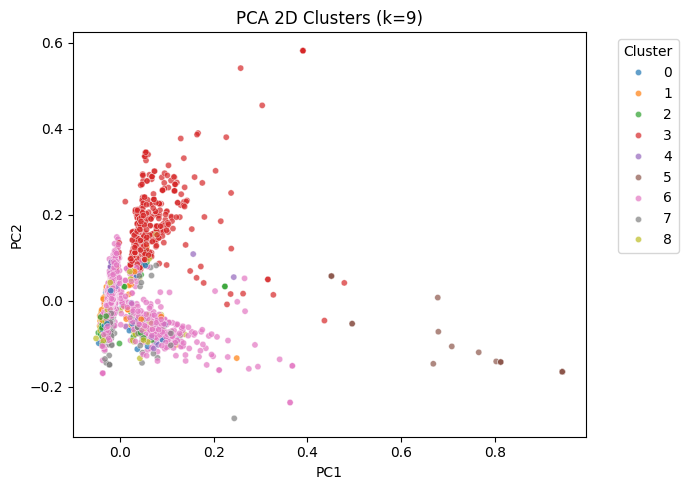

In [24]:
# Visualisasi PCA 2D
pca = PCA(n_components=2, random_state=42)
X_dense = X.toarray() if hasattr(X, 'toarray') else X
X_2d = pca.fit_transform(X_dense)

plt.figure(figsize=(7,5))
palette = sns.color_palette('tab10', n_colors=best_k)
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels, palette=palette, s=20, alpha=0.7, legend='brief')
plt.title(f'PCA 2D Clusters (k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualisasi centroid (aproksimasi): proyeksikan center ke PCA
centers_2d = pca.transform(km.cluster_centers_.dot(X_dense.T.dot(X_dense)) if X_dense.ndim==2 else km.cluster_centers_)
# Catatan: proyeksi centroid pada ruang PCA TF-IDF yang didensifikasi di atas adalah pendekatan kasar.



Shape Count: (5572, 3551)
n_topics=5: loglikelihood=-293316.76
n_topics=8: loglikelihood=-295098.92
n_topics=10: loglikelihood=-296270.51
n_topics=12: loglikelihood=-296416.08
n_topics=15: loglikelihood=-297706.04
n_topics=20: loglikelihood=-299176.99
Best n_topics: 5

Top words per topic:
Topic 0: good, day, happy, dont, take, dear, life, know, great, new, much, morning, care, well, year
Topic 1: ill, later, text, wat, sorry, get, lor, call, meet, come, see, time, help, free, txt
Topic 2: love, got, home, going, one, already, babe, lor, good, come, need, today, like, hey, dun
Topic 3: ltgt, dont, know, get, like, time, still, need, want, come, tell, anything, think, one, back
Topic 4: call, free, reply, mobile, stop, claim, please, txt, prize, phone, send, text, get, message, new
DocTopic shape: (5572, 5)
k=2: silhouette=0.2516
k=3: silhouette=0.3798
k=4: silhouette=0.4646
k=5: silhouette=0.5502
k=6: silhouette=0.5142
k=7: silhouette=0.4876
k=8: silhouette=0.4571
k=9: silhouette=0.462

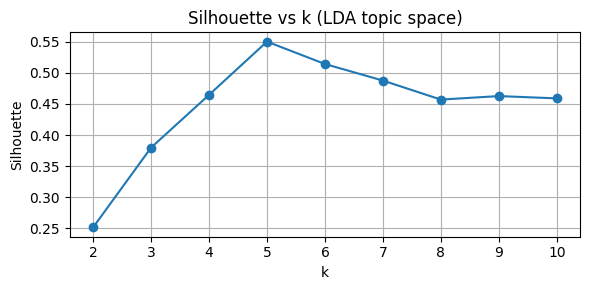

Best k (LDA space): 5
Disimpan ke: d:\Tugas Semester 7\PPWeb\UTS\spam_clusters_lda.csv


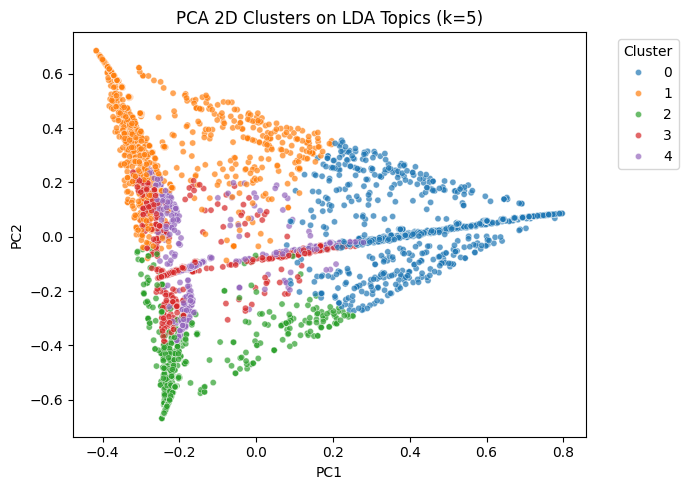

In [25]:
# LDA + KMeans clustering on topic distributions
# !pip install scikit-learn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize with Count (better for LDA)
count_vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,1), min_df=2)
X_count = count_vectorizer.fit_transform(processed)
print('Shape Count:', X_count.shape)

# Select number of topics by log-likelihood score (higher is better)
candidate_topics = [5, 8, 10, 12, 15, 20]
lda_models = {}
lda_scores = []
for n_t in candidate_topics:
    lda = LatentDirichletAllocation(
        n_components=n_t,
        learning_method='batch',
        random_state=42,
        max_iter=20,
        evaluate_every=0,
    )
    lda.fit(X_count)
    score = lda.score(X_count)
    lda_models[n_t] = lda
    lda_scores.append(score)
    print(f'n_topics={n_t}: loglikelihood={score:.2f}')

best_topics = candidate_topics[int(np.argmax(lda_scores))]
best_lda = lda_models[best_topics]
print('Best n_topics:', best_topics)

# Top words per topic
feature_names = np.array(count_vectorizer.get_feature_names_out())
num_top_words = 15
print('\nTop words per topic:')
for topic_idx, topic in enumerate(best_lda.components_):
    top_indices = np.argsort(topic)[::-1][:num_top_words]
    top_words = feature_names[top_indices]
    print(f'Topic {topic_idx}:', ', '.join(top_words))

# Document-topic distributions
DocTopic = best_lda.transform(X_count)
print('DocTopic shape:', DocTopic.shape)

# KMeans on topic distributions with silhouette selection
k_values = list(range(2, 11))
scores = []
for k in k_values:
    km_lda = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_lda = km_lda.fit_predict(DocTopic)
    score = silhouette_score(DocTopic, labels_lda, sample_size=1000 if DocTopic.shape[0]>1000 else None, random_state=42)
    scores.append(score)
    print(f'k={k}: silhouette={score:.4f}')

plt.figure(figsize=(6,3))
plt.plot(k_values, scores, marker='o')
plt.title('Silhouette vs k (LDA topic space)')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_lda = k_values[int(np.argmax(scores))]
print('Best k (LDA space):', best_k_lda)

# Final KMeans on DocTopic
km_final = KMeans(n_clusters=best_k_lda, random_state=42, n_init='auto')
labels_final = km_final.fit_predict(DocTopic)

# Output and save
out_lda = df[[id_col, text_col]].copy()
out_lda['cluster_lda'] = labels_final

out_csv = 'spam_clusters_lda.csv'
out_lda.to_csv(out_csv, index=False)
print('Disimpan ke:', os.path.abspath(out_csv))

# Optional: visualize in 2D (topic space)
pca_topics = PCA(n_components=2, random_state=42)
DocTopic_2d = pca_topics.fit_transform(DocTopic)
plt.figure(figsize=(7,5))
palette = sns.color_palette('tab10', n_colors=best_k_lda)
sns.scatterplot(x=DocTopic_2d[:,0], y=DocTopic_2d[:,1], hue=labels_final, palette=palette, s=20, alpha=0.7, legend='brief')
plt.title(f'PCA 2D Clusters on LDA Topics (k={best_k_lda})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
